In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np

In [2]:
pip install tensorflow-gpu

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/nutria
drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/red_fox
drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/sea_lions
drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/cougar
drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/raven
drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/deer
drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/bald_eagle
drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/raccoon
drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/virginia_opossum
drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/black_bear

total img num: 7168


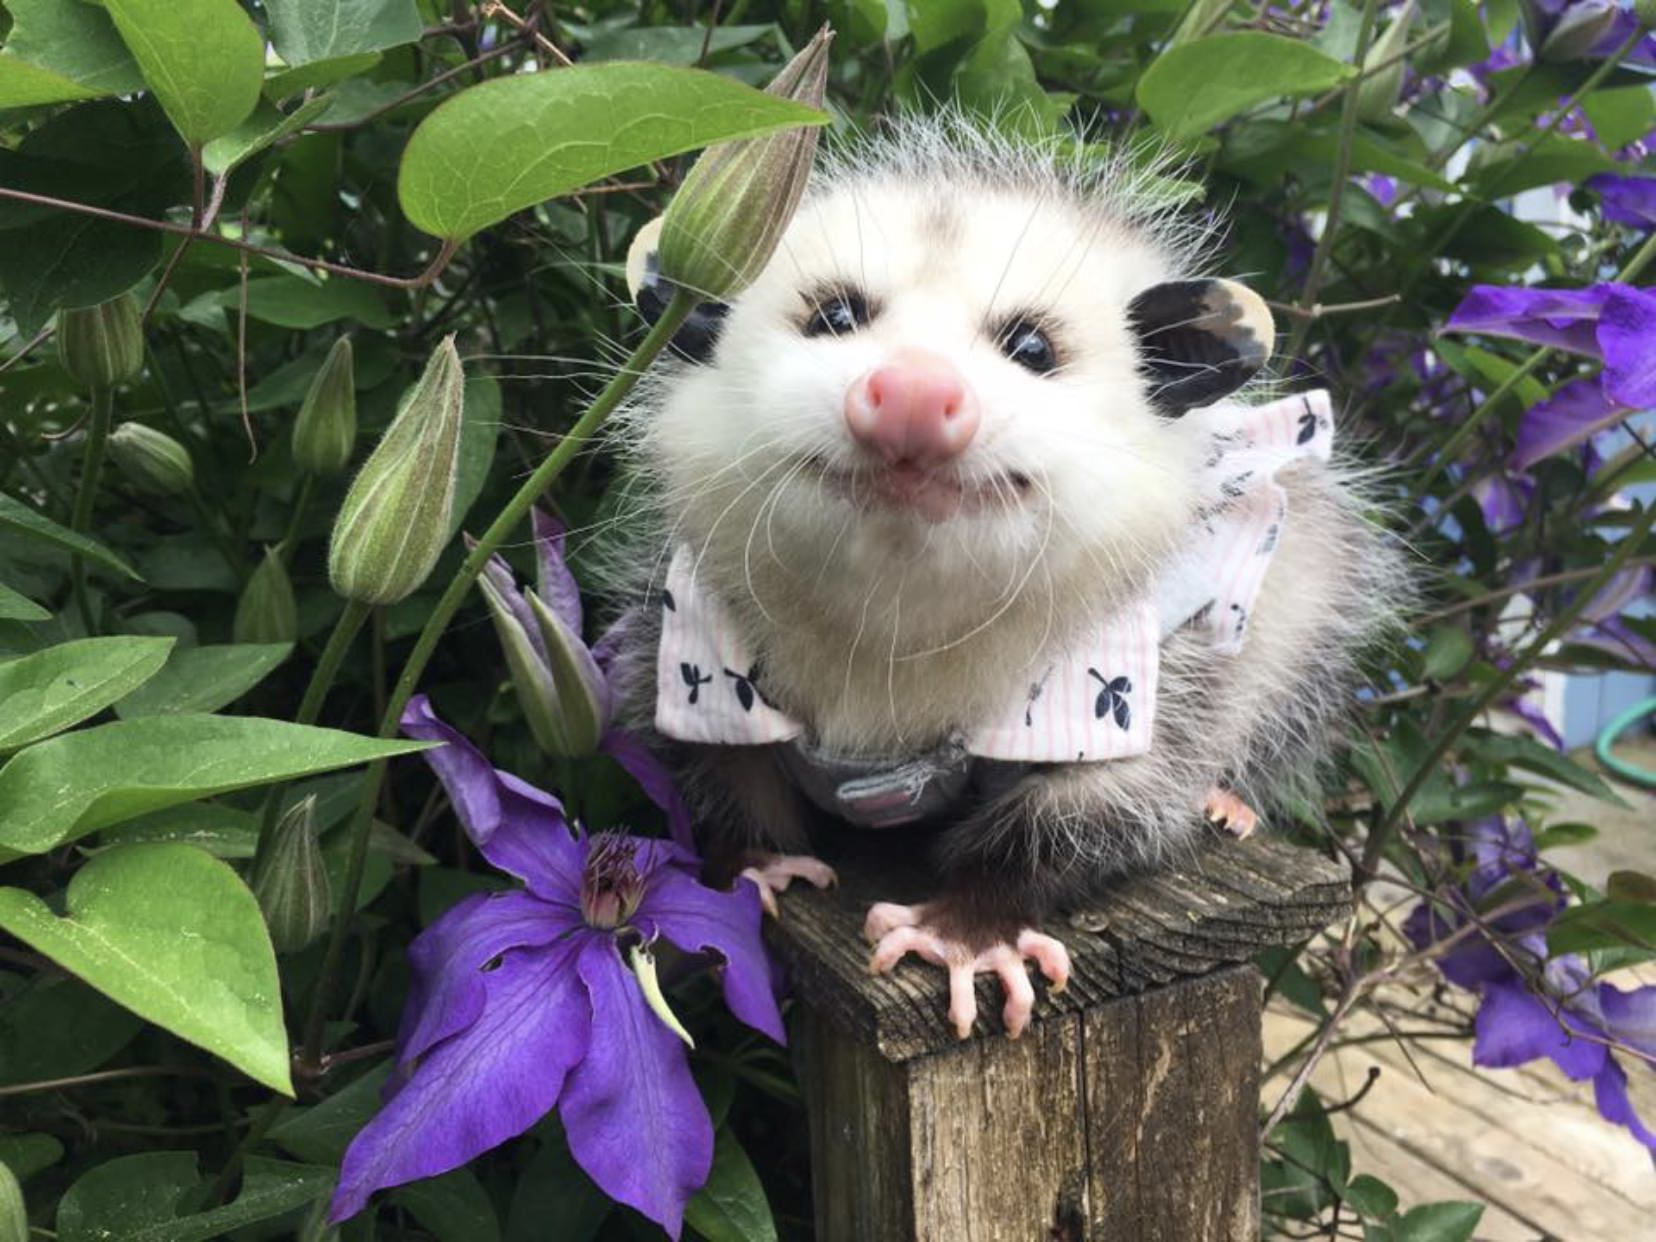

drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/virginia_opossum/0c3e460247dc102883.jpg


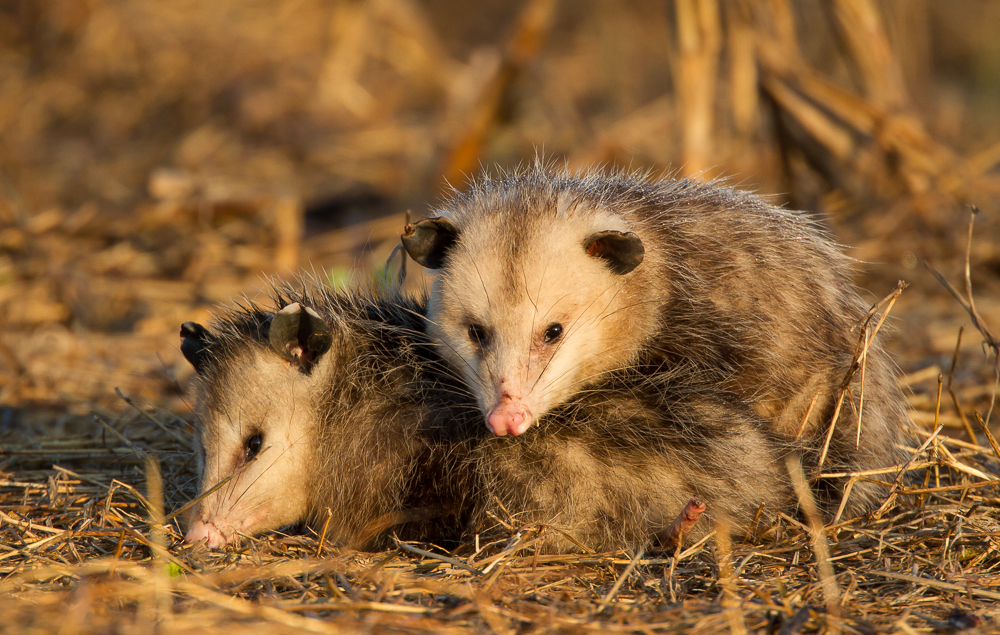

drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/virginia_opossum/b97c9b698a8bd0d742.jpg


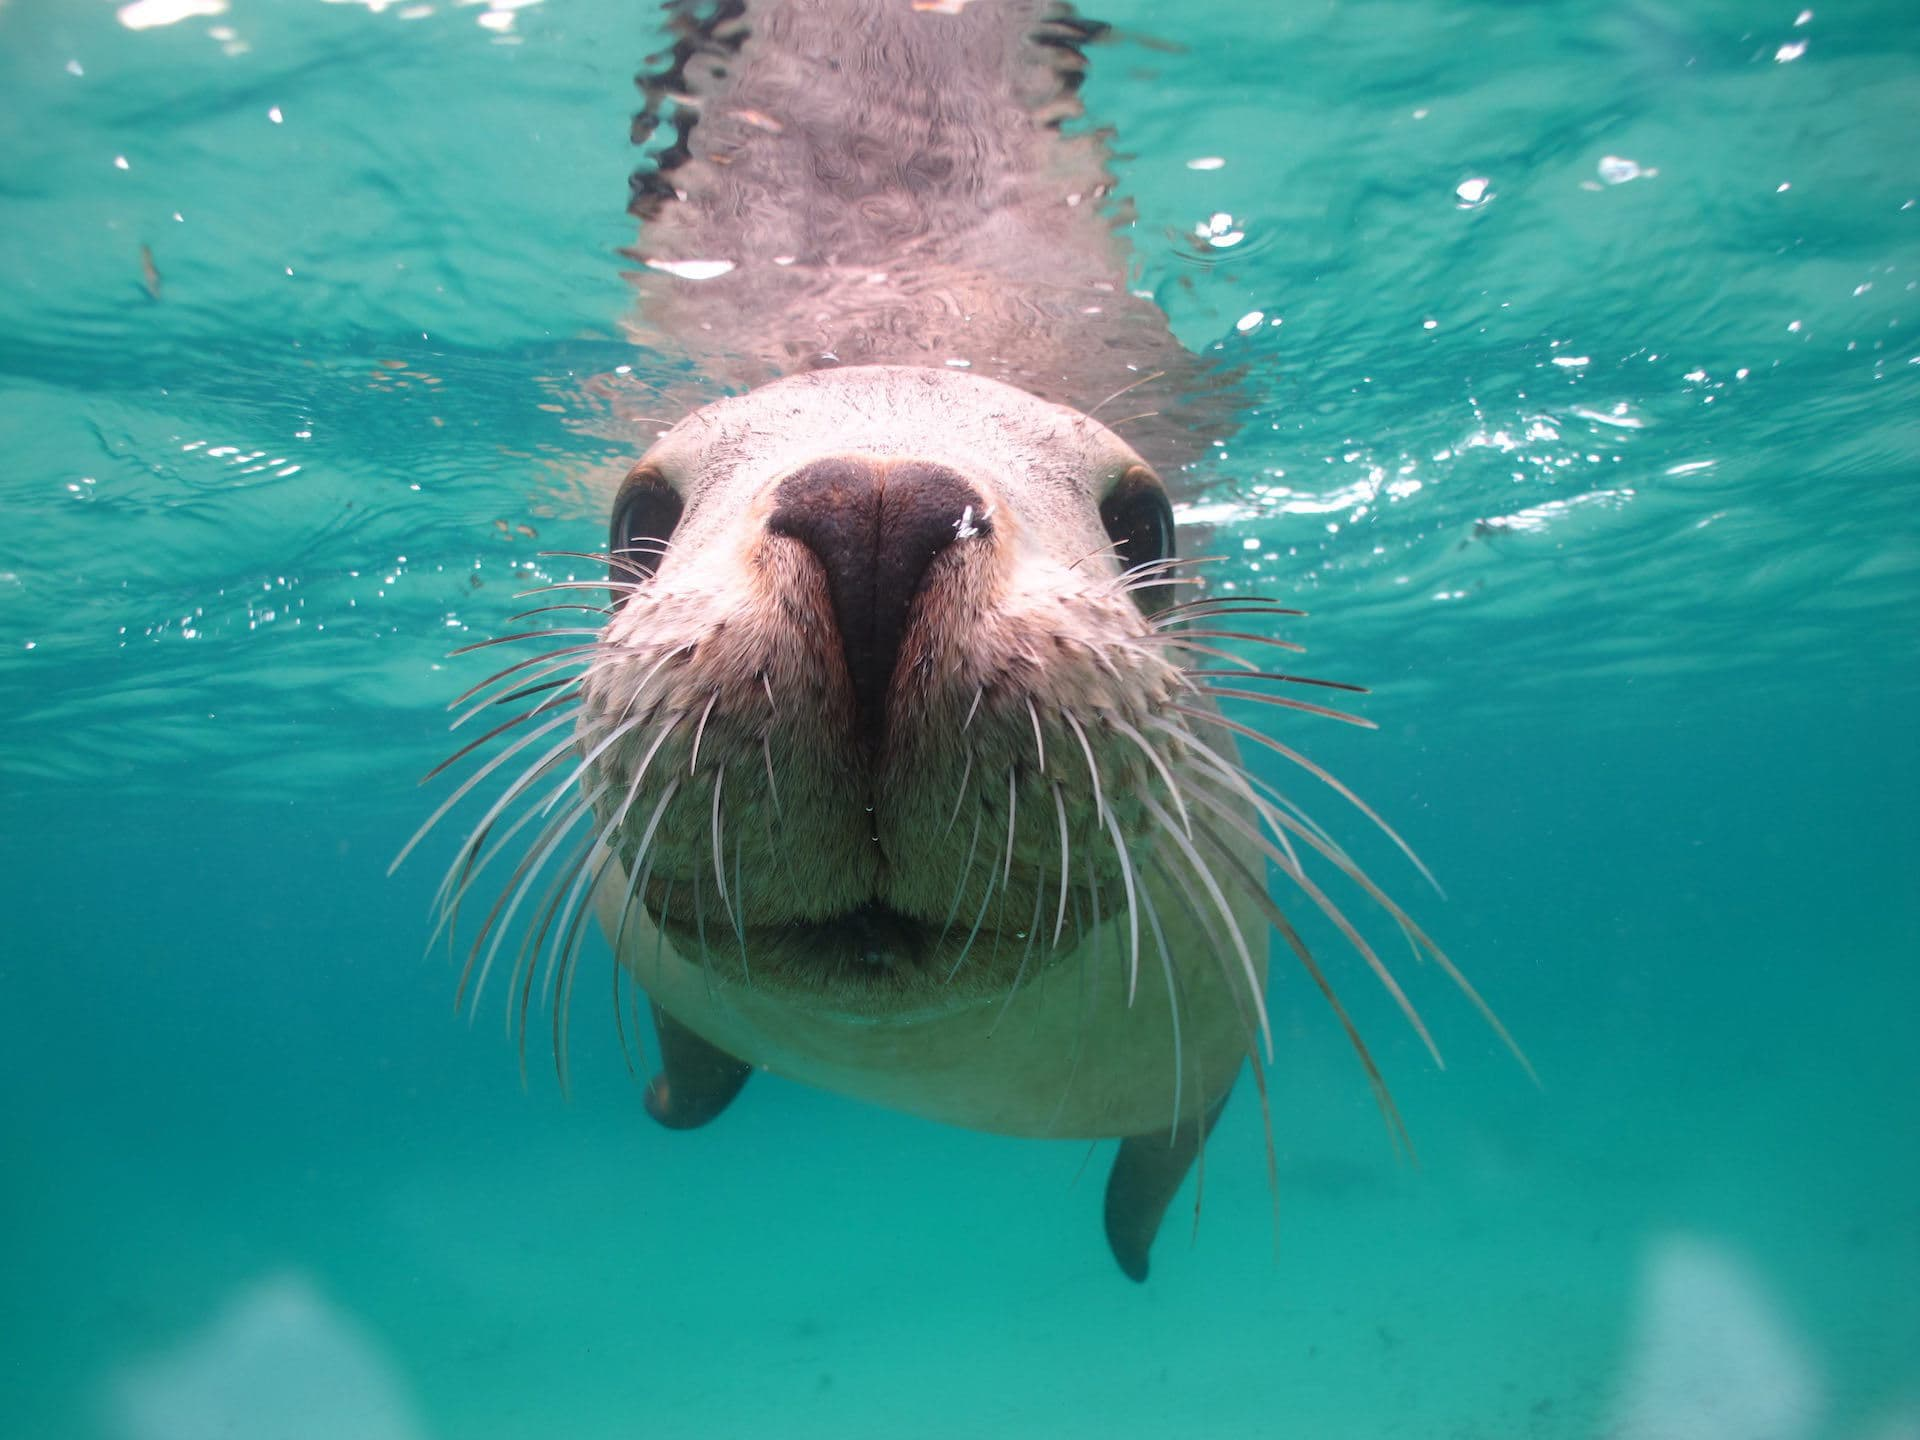

drive/My Drive/Colab Notebooks/Deep Learning/lab12/oregon_wildlife/sea_lions/4ea6d63c2aa4af049f.jpg


In [5]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('\\')[0])

In [6]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [7]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(index_to_label)

{0: 'bald_eagle', 1: 'black_bear', 2: 'cougar', 3: 'deer', 4: 'nutria', 5: 'raccoon', 6: 'raven', 7: 'red_fox', 8: 'sea_lions', 9: 'virginia_opossum'}


In [8]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [9, 3, 8, 3, 7, 8, 7, 4, 7, 4]


In [9]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [0]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


# feel free to modify these Settings.
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [0]:
# loda images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    label = tf.cast(label, tf.int64)
    return img, label

In [0]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
dataset_train = dataset_train.map(load_image)

dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
dataset_val = dataset_val.map(load_image)

# todo1: write the dataset above to tfrecord


In [0]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value = [value]))

def _float_feature(value):
    value = value.numpy().flatten()
    return tf.train.Feature(float_list=tf.train.FloatList(value= value))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
def serialize_example(feature0, feature1):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        'feature0': _float_feature(feature0),
        'feature1': _int64_feature(feature1)
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [0]:
def tf_serialize_example(f0,f1):
    tf_string = tf.py_function(
        serialize_example,
        (f0,f1),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar


In [0]:
# serialized_features_dataset = dataset_train.map(tf_serialize_example)
# filename = 'drive/My Drive/Colab Notebooks/Deep Learning/lab12/train.tfrecord'
# writer = tf.data.experimental.TFRecordWriter(filename)
# writer.write(serialized_features_dataset) 

# serialized_features_dataset_1 = dataset_val.map(tf_serialize_example)
# filename_1 = 'drive/My Drive/Colab Notebooks/Deep Learning/lab12/val.tfrecord'
# writer_1 = tf.data.experimental.TFRecordWriter(filename_1)
# writer_1.write(serialized_features_dataset_1)  

# todo2: read the data from tfrecord you get in Todo1

In [0]:
def _parse_function(example_proto):
  feature_description =   {
                            'feature0': tf.io.FixedLenFeature([270000], tf.float32),
                            'feature1': tf.io.FixedLenFeature([1], tf.int64),
                          }
  parsed_features = tf.io.parse_single_example(example_proto, feature_description)
  img   = tf.reshape(parsed_features['feature0'], (300,300,3))
  label = parsed_features["feature1"][0]
  return img, label

# todo3: remember to preprocess the data. You can refer to the code in the Cifar10 section.

In [0]:
def load_tfrecords(srcfile):
    dataset = tf.data.TFRecordDataset(srcfile)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.map(map_func =_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [0]:
dataset_train = load_tfrecords('drive/My Drive/Colab Notebooks/Deep Learning/lab12/train.tfrecord')
dataset_val   = load_tfrecords('drive/My Drive/Colab Notebooks/Deep Learning/lab12/val.tfrecord')

(300, 300, 3)


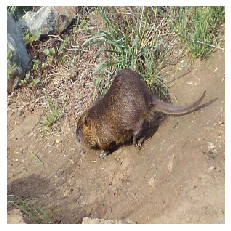

nutria


In [20]:
# show one image here.
temp = tf.data.TFRecordDataset('drive/My Drive/Colab Notebooks/Deep Learning/lab12/train.tfrecord')
temp = temp.map(map_func = _parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
for data in temp.take(1):
    img = data[0]
    label = data[1]
    print(img.shape)
    plt.imshow(img) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label.numpy()])

In [21]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

58892288/58889256 [==============================] - 2s 0us/step


In [22]:
wild_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

wild_model.fit(dataset_train, validation_data=dataset_val, epochs=5)

Epoch 1/5
90/90 [==============================] - 130s 1s/step - loss: 5.1336 - accuracy: 0.2286 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
90/90 [==============================] - 77s 856ms/step - loss: 1.2464 - accuracy: 0.5732 - val_loss: 0.6422 - val_accuracy: 0.8117
Epoch 3/5
90/90 [==============================] - 77s 855ms/step - loss: 0.8452 - accuracy: 0.7173 - val_loss: 0.5508 - val_accuracy: 0.8626
Epoch 4/5
90/90 [==============================] - 77s 857ms/step - loss: 0.7033 - accuracy: 0.7579 - val_loss: 0.4871 - val_accuracy: 0.8640
Epoch 5/5
90/90 [==============================] - 77s 856ms/step - loss: 0.5895 - accuracy: 0.7996 - val_loss: 0.4604 - val_accuracy: 0.8515
